In [1]:
library(tidyverse)
library(data.table)
library(EvolutionaryGames)
library(ggthemes)
library(latex2exp)
library(ggtext)

setwd("D:/R/RStudio/project/PLA20220809")


duplicate_dynamic<-function(y,M,beta,d,N,c){
  
  #-----参数解释说明------#
  # #N个个体
  # N<-4
  # #M资源 c(5,15,25)
  # M<-5
  # #less effort的成本
  # c<-1
  # #投入效用
  # beta<-1
  # #more effort的成本
  # d<-4
  #-----------------------#
  
  #这里决定用N-1
  #需要取整
  Nd<-floor(y*(N-1)) 
  Nc<-N-1-Nd
  
  #策略c（cooperate, less effort）和策略d(defect，more effort)的收益
  #（1）个体选择策略c的期望收益
  pai_c<-(c*M)/((Nc+1)*c+Nd*beta*d)-c
  #（2）个体选择策略d的期望收益
  pai_d<-(beta*d*M)/(Nc*c+(Nd+1)*beta*d)-d
  
  #群体体选择策略c或d的收益  = 概率*pai
  #等价Pc<(choose(N-1, Nc)*((1-y)^Nc)*(y^Nd))*pai_c
  Pc<-(choose(N-1, Nd)*(y^Nd)*((1-y)^Nc))*pai_c
  Pd<-(choose(N-1, Nd)*(y^Nd)*((1-y)^Nc))*pai_d #choose计算组合数
  
  #（3）群体选择策略d的平均收益
  R_<-y*Pd+(1-y)*Pc
  
  #(4)复制动态方程
  #y.<-y(Pd-R_) = y(Pd-y*Pd-(1-y)*Pc) = y(1-y)(Pd-Pc)
  y.<-y*(1-y)*(Pd-Pc)
}

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose




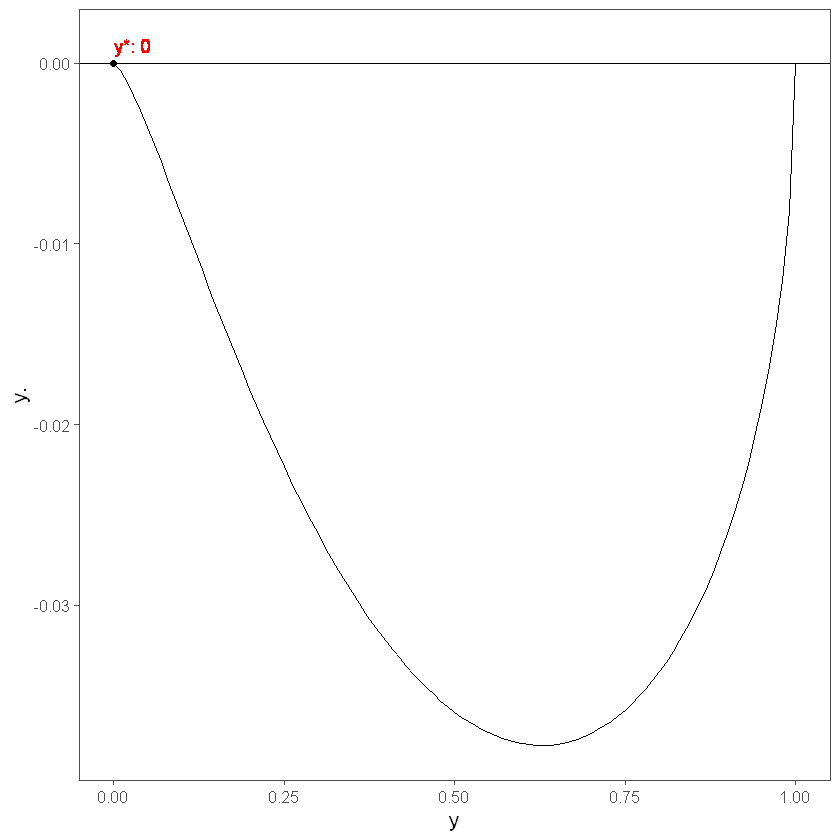

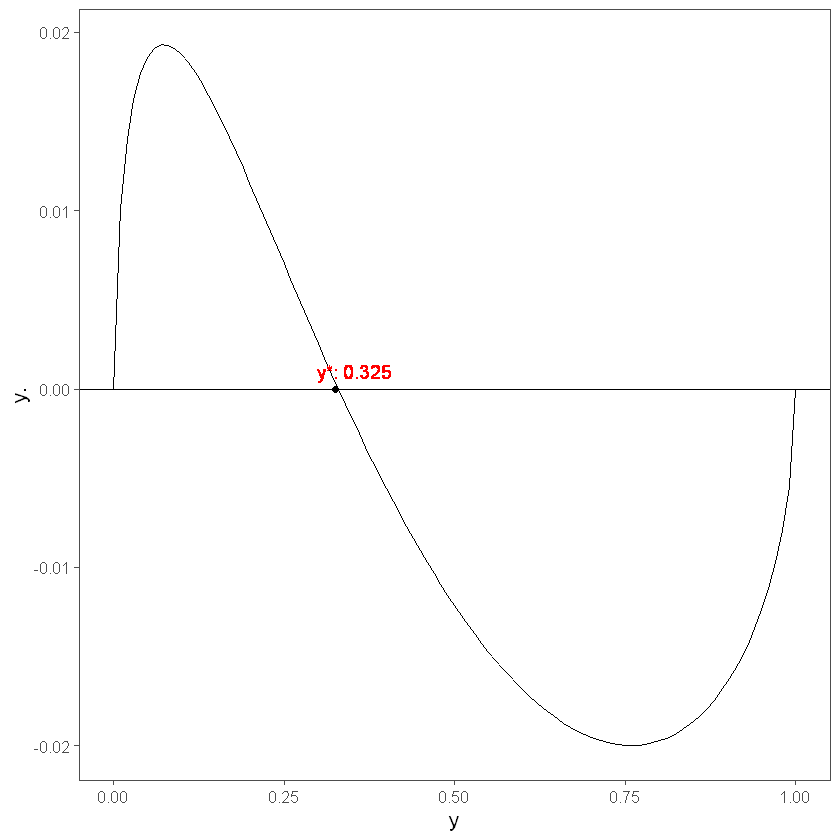

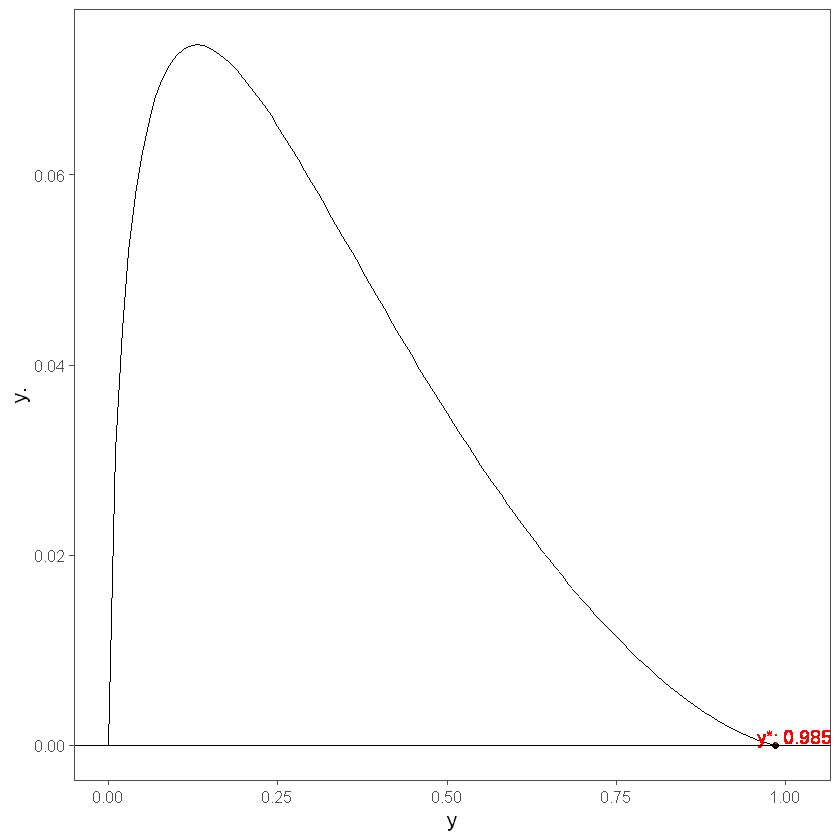

In [2]:
#----------------------------------------------------------------------#
#------------------------------图1-------------------------------------#
#----------------------------------------------------------------------#
plot_y._y<-function(M){
  y.<-c()
  
  for(y in seq(0, 1, 0.01)){
    temp<-duplicate_dynamic(y,M,beta=1,d=4,N=100,c=1)
    
    # N: 个体数
    # M: 资源 c(5,15,25)
    # c: less effort的成本
    # beta: 投入效用
    # d: more effort的成本
    
    y.<-c(y.,temp)
  }
  
  df <- data.frame(x = seq(0, 1, 0.01), y = y.) %>% 
    mutate(y1=c(y.[-1],1)) %>% 
    mutate(y0=y*y1)
  
  #ystar<-df$x[df$y0<0]+0.005 #即横坐标
  
  ystar<-ifelse(sum(df$x[df$y0<0])==0,0,df$x[df$y0<0]+0.005)
  
  ggplot(df,aes(x=x,y=y))+
    geom_line(color="black",size=0.3)+
    theme_few() +
    geom_point(aes(x=ystar,y=0))+
    geom_text(aes(x=ystar,y=0),label=paste("y*:",ystar),size=4,nudge_y = 0.001,nudge_x = 0.03,color="red")+
    geom_hline(aes(yintercept = 0),size=0.3)+
    labs(x = "y", y = "y.")
}


#---1. fig1 (a1)---#
plot_y._y(M=100)

#---2. fig1 (b1)---#
plot_y._y(M=200)

#---3. fig1 (c1)---#
plot_y._y(M=398)#右临界资源值

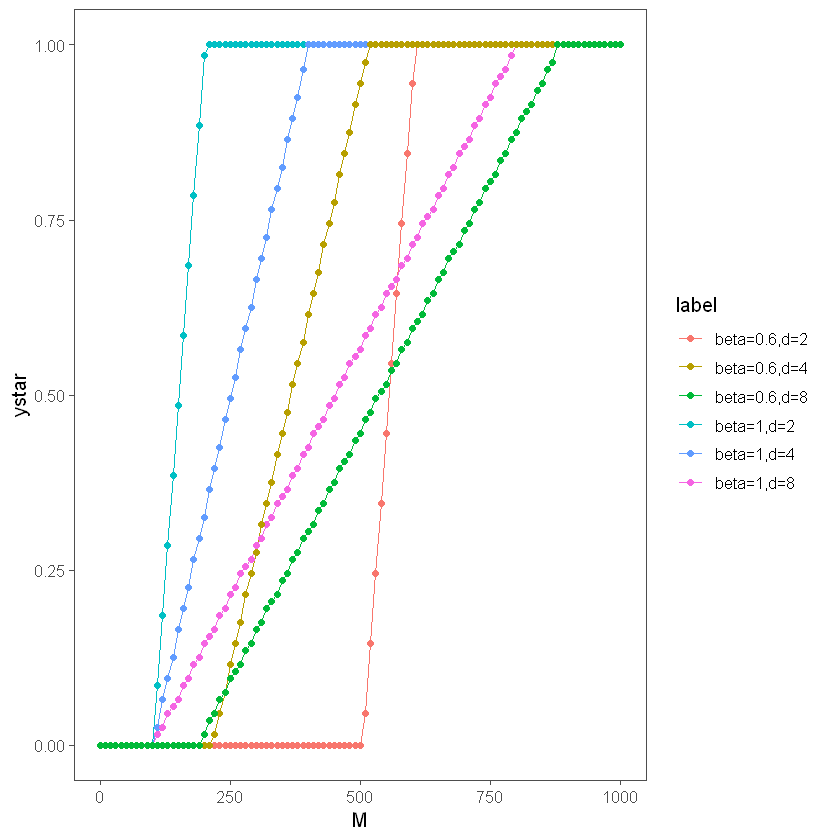

In [3]:
#----------------------------------------------------------------------#
#------------------------------图2-------------------------------------#
#----------------------------------------------------------------------#
ystar_collect<-function(M,beta,d){
  
  y.<-c()
  
  for(y in seq(0, 1, 0.01)){
    temp<-duplicate_dynamic(y,M,beta,d,N=100,c=1)
    
    # N: 个体数
    # M: 资源 c(5,15,25)
    # c: less effort的成本
    # beta: 投入效用
    # d: more effort的成本
    
    y.<-c(y.,temp)
  }
  
  df <- data.frame(x = seq(0, 1, 0.01), y = y.) %>% 
    mutate(y1=c(y.[-1],1)) %>% 
    mutate(y0=y*y1)
  
  #ystar<-ifelse(sum(df$x[df$y0<0])==0,0,df$x[df$y0<0]+0.005)
  if(all(df$y<=0)){
    ystar<-0 
  }else if(all(df$y>=0)){
    ystar<-1
  }else{
    ystar<-df$x[df$y0<0]+0.005
  }
  
  return(ystar)
}

#均衡ystar值收集
parameters<-data.frame(beta=c(1,1,1,0.6,0.6,0.6),d=c(2,4,8,2,4,8))

result<-data.frame()

for(i in 1:6){
  beta<-parameters$beta[i]
  d<-parameters$d[i]
  
  ystars<-c()
  
  for (M in seq(0,1000,10)){
    temp<-ystar_collect(M,beta,d)
    ystars<-c(ystars,temp)
  }
  
  data<-data.frame(beta=rep(beta,length(ystars)),d=rep(d,length(ystars)),M=seq(0,1000,10),ystar=ystars)
  
  result<-rbind(result,data)
}

#数据可视化
df<-result %>% 
  mutate(label=paste("beta=",beta,",","d=",d,sep=""))

ggplot(df,aes(x=M,y=ystar,color=label))+
  geom_line()+
  geom_point()+
  theme_few()

In [10]:
## Fig3

ystar_collect<-function(M,beta,d){
  
  y.<-c()
  
  for(y in seq(0, 1, 0.01)){
    temp<-duplicate_dynamic(y,M,beta,d,N=100,c=1)
    
    # N: 个体数
    # M: 资源 c(5,15,25)
    # c: less effort的成本
    # beta: 投入效用
    # d: more effort的成本
    
    y.<-c(y.,temp)
  }
  
  df <- data.frame(x = seq(0, 1, 0.01), y = y.) %>% 
    mutate(y1=c(y.[-1],1)) %>% 
    mutate(y0=y*y1)
  
  #ystar<-ifelse(sum(df$x[df$y0<0])==0,0,df$x[df$y0<0]+0.005)
  if(all(df$y<=0)){
    ystar<-0 
  }else if(all(df$y>0)){
    ystar<-1
  }else{
    ystar<-df$x[df$y0<0]+0.005
  }
  
  return(ystar)
}
parameters<-data.frame(M=c(50,50,50,25,25,25),d=c(2,4,8,2,4,8))
result<-data.frame()
for(i in 1:6){
  M<-parameters$M[i]
  d<-parameters$d[i]
  
  ystars<-c()
  
  for (beta in seq(0,1.2,0.2)){
    temp<-ystar_collect(M,beta,d)
    ystars<-c(ystars,temp)
  }
  
  data<-data.frame(M=rep(M,length(ystars)),d=rep(d,length(ystars)),beta=seq(0,1.2,0.2),ystar=ystars)
  
  result<-rbind(result,data)
}
#数据可视化
df<-result %>% 
  mutate(label=paste("M=",M,",","d=",d,sep=""))

ggplot(df,aes(x=beta,y=ystar,color=label))+
  geom_line()+
  geom_point()+
  theme_few()

ERROR: Error in if (all(df$y <= 0)) {: missing value where TRUE/FALSE needed


In [12]:
## Fig4

ystar_collect<-function(M,beta,d){
  
  y.<-c()
  
  for(y in seq(0, 1, 0.01)){
    temp<-duplicate_dynamic(y,M,beta,d,N=100,c=1)
    
    # N: 个体数
    # M: 资源 c(5,15,25)
    # c: less effort的成本
    # beta: 投入效用
    # d: more effort的成本
    
    y.<-c(y.,temp)
  }
  
  df <- data.frame(x = seq(0, 1, 0.01), y = y.) %>% 
    mutate(y1=c(y.[-1],1)) %>% 
    mutate(y0=y*y1)
  
  #ystar<-ifelse(sum(df$x[df$y0<0])==0,0,df$x[df$y0<0]+0.005)
  if(all(df$y<=0)){
    ystar<-0 
  }else if(all(df$y>=0)){
    ystar<-1
  }else{
    ystar<-df$x[df$y0<0]+0.005
  }
  
  return(ystar)
}
parameters<-data.frame(M=c(20,25,40,20,25,40),beta=c(1,1,1,0.6,0.6,0.6))
result<-data.frame()
for(i in 1:6){
  M<-parameters$M[i]
  beta<-parameters$beta[i]
  
  ystars<-c()
  
  for (d in seq(0,20,5)){
    temp<-ystar_collect(M,beta,d)
    ystars<-c(ystars,temp)
  }
  
  data<-data.frame(M=rep(M,length(ystars)),d=seq(0,20,5),beta=rep(beta,length(ystars)),ystar=ystars)
  
  result<-rbind(result,data)
}
#数据可视化
df<-result %>% 
  mutate(label=paste("M=",M,",","beta=",beta,sep=""))

ggplot(df,aes(x=d,y=ystar,color=label))+
  geom_line()+
  geom_point()+
  theme_few()

ERROR: Error in data.frame(M = rep(M, length(ystars)), d = seq(0, 20, 5), beta = rep(beta, : arguments imply differing number of rows: 6, 5
